In [1]:
import os, sys
sys.path.append(os.getcwd())

from src.stress import kernel_curve
from src.features import merge_ret_vs_liq


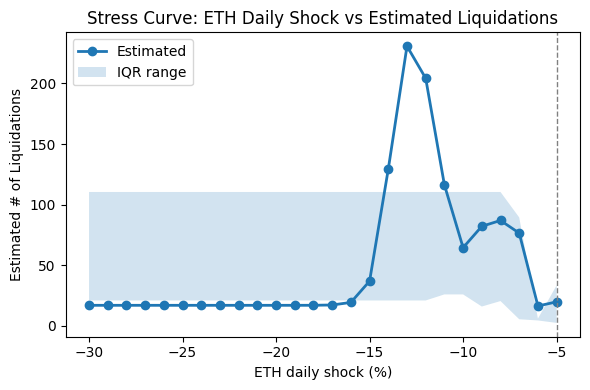

✅ Saved: data/stress_curve.csv, figs/stress_curve.png


In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os

os.makedirs("data", exist_ok=True); os.makedirs("figs", exist_ok=True)

# 读取/保障数据
if "merged" not in globals():
    merged = pd.read_csv("data/eth_ret_vs_liq.csv", parse_dates=["date"])
m = merged.dropna(subset=["ret","liq_cnt"]).copy()
m["ret"] = m["ret"].astype(float)
m["liq_cnt"] = m["liq_cnt"].astype(float)

# 对日期排序并计算 7 日累计收益（跌幅为负数）
m = m.sort_values("date")
m["ret7"] = m["ret"].rolling(7, min_periods=3).sum()
# 移除缺失值
m = m.dropna(subset=["ret7"]).reset_index(drop=True)


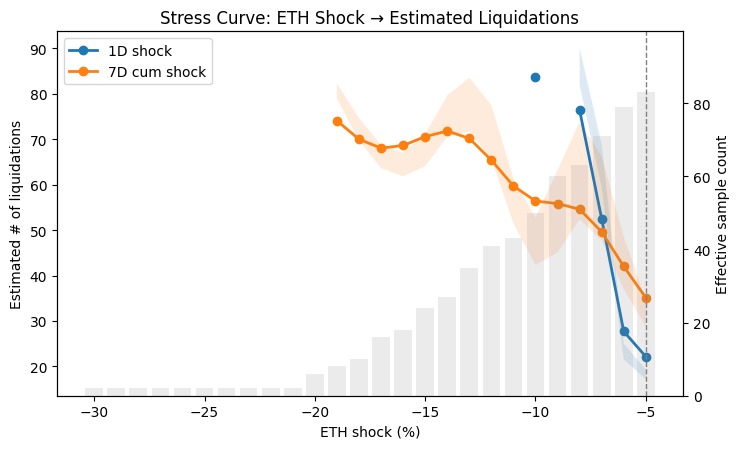

Saved: data/stress_curve_1d.csv, data/stress_curve_7d.csv, figs/stress_curve_compare.png


In [2]:
grid = np.arange(-0.30, -0.04, 0.01)  # -30% ~ -5%
curve1 = kernel_curve(m["ret"],  m["liq_cnt"], grid, sigma=0.012)   # 单日
curve7 = kernel_curve(m["ret7"], m["liq_cnt"], grid, sigma=0.020)   # 7日累计（带宽更大）

curve1.to_csv("data/stress_curve_1d.csv", index=False)
curve7.to_csv("data/stress_curve_7d.csv", index=False)

# --- 3) 画图：两条曲线 + 置信带 + 覆盖度 ---
fig, ax = plt.subplots(figsize=(7.5,4.6))
ax.plot(curve1["shock"]*100, curve1["est"], marker="o", lw=2, label="1D shock")
ax.fill_between(curve1["shock"]*100, curve1["p25"], curve1["p75"], alpha=0.15)

ax.plot(curve7["shock"]*100, curve7["est"], marker="o", lw=2, label="7D cum shock")
ax.fill_between(curve7["shock"]*100, curve7["p25"], curve7["p75"], alpha=0.15)

ax.axvline(-5, ls="--", lw=1, color="gray")
ax.set_title("Stress Curve: ETH Shock → Estimated Liquidations")
ax.set_xlabel("ETH shock (%)")
ax.set_ylabel("Estimated # of liquidations")
ax.legend(loc="upper left")

# 覆盖度（右轴）：每个shock附近的有效样本量
ax2 = ax.twinx()
eff = np.nan_to_num(np.maximum(curve1["effN"], curve7["effN"]))
ax2.bar(curve1["shock"]*100, eff, width=0.8, alpha=0.15, color="tab:gray")
ax2.set_ylabel("Effective sample count")
ax2.set_ylim(0, max(5, eff.max()*1.2))

plt.tight_layout()
plt.savefig("figs/stress_curve_compare.png", dpi=200)
plt.show()

print("Saved: data/stress_curve_1d.csv, data/stress_curve_7d.csv, figs/stress_curve_compare.png")
